In [1]:
#Python-related imports
from datetime import datetime
import os.path

#PyData imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Torch-related imports
import torch
import torch.distributions as D
import torch.nn.functional as F
import torch.optim as optim
from scipy.optimize import bisect
from torch.autograd import Function

#Module imports


In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)
    
from LogitNormal import *

In [3]:
torch.manual_seed(2)
np.random.seed(2)

torch.set_printoptions(precision = 8)

In [4]:
def find_scale(scale, loc, a, b, target_sd):
    x = RescaledLogitNormal(loc, scale, a, b)
    #print(scale, x.mean, x.stddev)
    #print(x.stddev - target_sd)
    return x.stddev - target_sd

In [5]:
SCON_SS_priors_details = {k: v for k, v in torch.load(os.path.join('generated_data/', 'SCON-SS_CO2_logit_short_2021_11_17_20_16_sample_y_t_5000_dt_0-01_sd_scale_0-25_hyperparams.pt')).items()}
print(SCON_SS_priors_details)
stochastic_parameters = ['s_SOC', 's_DOC', 's_MBC']
SCON_SS_priors_details = dict([(k, v) for k, v in SCON_SS_priors_details.items() if k not in stochastic_parameters])
print(SCON_SS_priors_details)

keys = list(SCON_SS_priors_details.keys())

prior_list = list(zip(*(SCON_SS_priors_details[k] for k in list(SCON_SS_priors_details.keys()))))
prior_means_tensor, prior_sds_tensor, prior_lowers_tensor, prior_uppers_tensor = torch.tensor(prior_list)
p_theta = RescaledLogitNormal(loc = prior_means_tensor, scale = prior_sds_tensor, a = prior_lowers_tensor, b = prior_uppers_tensor)

lower = prior_lowers_tensor
upper = prior_uppers_tensor

{'u_M': tensor([-4.11903715,  0.24392651,  0.00000000,  0.10000000]), 'a_SD': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'a_DS': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'a_M': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'a_MSC': tensor([0.00000000, 0.53270835, 0.00000000, 1.00000000]), 'k_S_ref': tensor([-5.29330492,  0.24083881,  0.00000000,  0.10000000]), 'k_D_ref': tensor([-4.82028151,  0.24167340,  0.00000000,  0.10000000]), 'k_M_ref': tensor([-4.95482063,  0.24139453,  0.00000000,  0.10000000]), 'Ea_S': tensor([-1.38629436,  0.41090810,  5.00000000, 80.00000000]), 'Ea_D': tensor([-1.38629436,  0.41090810,  5.00000000, 80.00000000]), 'Ea_M': tensor([-1.38629436,  0.41090810,  5.00000000, 80.00000000]), 's_SOC': tensor([-5.29330492,  0.24083881,  0.00000000,  0.10000000]), 's_DOC': tensor([-5.29330492,  0.24083881,  0.00000000,  0.10000000]), 's_MBC': tensor([-5.29330492,  0.24083881,  0.00000000,  0.10000000])}
{'u_M': tensor([-4.11903

In [6]:
true_theta = torch.load(os.path.join('generated_data/', 'SCON-SS_CO2_logit_short_2021_11_17_20_16_sample_y_t_5000_dt_0-01_sd_scale_0-25_rsample.pt'))
print(true_theta)

{'u_M': array(0.00175785, dtype=float32), 'a_SD': array(0.47026154, dtype=float32), 'a_DS': array(0.45755228, dtype=float32), 'a_M': array(0.34480965, dtype=float32), 'a_MSC': array(0.6356179, dtype=float32), 'k_S_ref': array(0.00042958, dtype=float32), 'k_D_ref': array(0.00091775, dtype=float32), 'k_M_ref': array(0.00079687, dtype=float32), 'Ea_S': array(18.160398, dtype=float32), 'Ea_D': array(15.5049715, dtype=float32), 'Ea_M': array(27.544662, dtype=float32), 's_SOC': array(0.00059805, dtype=float32), 's_DOC': array(0.00036377, dtype=float32), 's_MBC': array(0.00037128, dtype=float32)}


In [7]:
df = pd.read_csv(os.path.join('NUTS_results/', 'CON_CO2_NUTS_inference_SCON-SS_data_post_5000.csv'))
df_post = df.loc[:, 'u_M':'Ea_M']
print(df_post)

           u_M      a_SD      a_DS       a_M     a_MSC   k_S_ref   k_D_ref  \
0     0.002296  0.317323  0.435647  0.551406  0.187091  0.000460  0.000455   
1     0.002483  0.325087  0.451744  0.591248  0.144725  0.000461  0.000532   
2     0.002572  0.330971  0.463257  0.598592  0.106085  0.000458  0.000559   
3     0.002367  0.314626  0.432398  0.574492  0.099318  0.000453  0.000513   
4     0.002549  0.319294  0.436482  0.563031  0.172112  0.000454  0.000389   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.002388  0.318018  0.434643  0.533486  0.219529  0.000454  0.000313   
9996  0.002438  0.317218  0.433654  0.550174  0.196804  0.000458  0.000355   
9997  0.002503  0.330404  0.452759  0.542320  0.203011  0.000460  0.000391   
9998  0.002436  0.319024  0.437471  0.625219  0.154753  0.000463  0.000547   
9999  0.002598  0.320000  0.445661  0.615499  0.104925  0.000457  0.000550   

       k_M_ref     Ea_S     Ea_D     Ea_M  
0     0.000938  5.0

<AxesSubplot:xlabel='u_M', ylabel='Density'>

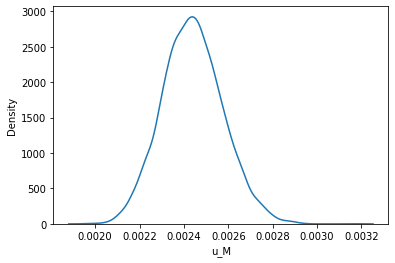

In [8]:
sns.kdeplot(data = df_post, x = "u_M")

In [9]:
x0 = torch.max(p_theta.mean - 4 * p_theta.stddev, lower).detach()
x1 = torch.min(p_theta.mean + 4 * p_theta.stddev, upper).detach()

print(x0)
print(x1)

num_pts = 1000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf = torch.exp(p_theta.log_prob(x)).detach()

tensor([4.58894065e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.44800870e-05, 2.31056474e-05, 2.02373485e-05,
        5.00000000e+00, 5.00000000e+00, 5.00000000e+00])
tensor([3.24588595e-03, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.01448025e-03, 1.62310968e-03, 1.42023643e-03,
        4.05847702e+01, 4.05847702e+01, 4.05847702e+01])


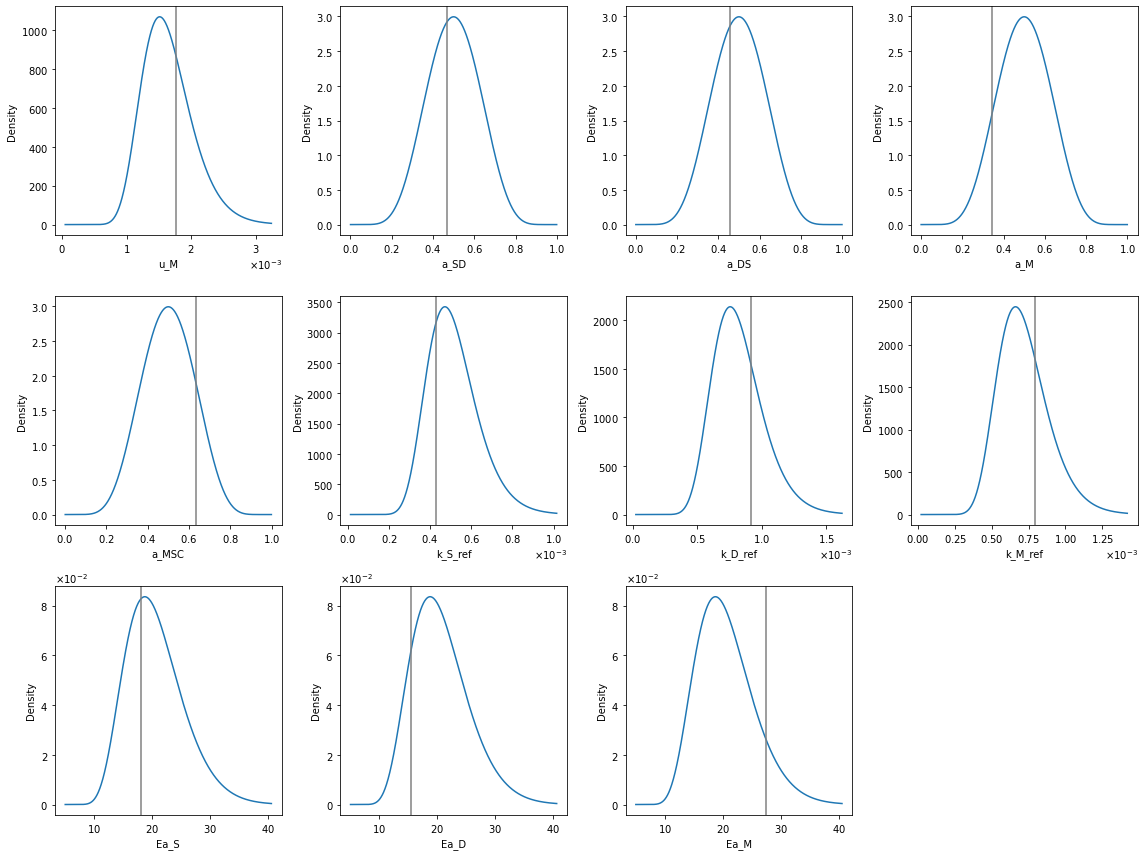

In [10]:
num_params = len(SCON_SS_priors_details)
ncols = 4
nrows = int(num_params / ncols) + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = np.atleast_2d(axes)
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < num_params:
            key = keys[k]
            ax.plot(x[:, k], pdf[:, k])
            ax.axvline(true_theta[key], color='gray')
            ax.set_xlabel(key)
            ax.set_ylabel('Density')
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='both', useMathText='True')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()

In [11]:
#Create approximate posterior q_dist to facilitate plotting of posterior KDE densities.

#Parameter posterior summary means
u_M_mean = 0.002439216126
a_SD_mean = 0.437
a_DS_mean = 0.3226127112
a_M_mean = 0.4423761998
a_MSC_mean = 0.5736054091
k_S_ref_mean = 0.0004600970287
k_D_ref_mean = 0.0004638526317
k_M_ref_mean = 0.0009972983784
Ea_S_mean = 5.316008697
Ea_D_mean = 28.35567616
Ea_M_mean = 47.2409119

#Parameter posterior summary sds
u_M_sd = 0.000137130548715854
a_SD_sd = 0.00754497983256827
a_DS_sd = 0.0101839213107037
a_M_sd = 0.0288988434750104
a_MSC_sd = 0.0568094272590353
k_S_ref_sd = 4.51120592586581E-06
k_D_ref_sd = 0.0000842837207669244
k_M_ref_sd = 0.0000673369969945826
Ea_S_sd = 0.276542633360172
Ea_D_sd = 2.78795913251541
Ea_M_sd = 1.40428583774664

#SCON theta logit-normal distribution parameter details in order of mean, sdev, lower, and upper.
u_M_details = torch.Tensor([u_M_mean, u_M_sd, 0, 0.1])
a_SD_details = torch.Tensor([a_SD_mean, a_SD_sd, 0, 1])
a_DS_details = torch.Tensor([a_DS_mean, a_DS_sd, 0, 1])
a_M_details = torch.Tensor([a_M_mean, a_M_sd, 0, 1])
a_MSC_details = torch.Tensor([a_MSC_mean, a_MSC_sd, 0, 1])
k_S_ref_details = torch.Tensor([k_S_ref_mean, k_S_ref_sd, 0, 0.1])
k_D_ref_details = torch.Tensor([k_D_ref_mean, k_D_ref_sd, 0, 0.1])
k_M_ref_details = torch.Tensor([k_M_ref_mean, k_M_ref_sd, 0, 0.1])
Ea_S_details = torch.Tensor([Ea_S_mean, Ea_S_sd, 5, 80])
Ea_D_details = torch.Tensor([Ea_D_mean, Ea_D_sd, 5, 80])
Ea_M_details = torch.Tensor([Ea_M_mean, Ea_M_sd, 5, 80])

posteriors = {'u_M': u_M_details, 'a_SD': a_SD_details, 'a_DS': a_DS_details, 'a_M': a_M_details, 'a_MSC': a_MSC_details, 'k_S_ref': k_S_ref_details, 'k_D_ref': k_D_ref_details, 'k_M_ref': k_M_ref_details, 'Ea_S': Ea_S_details, 'Ea_D': Ea_D_details, 'Ea_M': Ea_M_details}

In [12]:
scale_lower = 1e-8 #Lower bound for scale search by bisect function.
scale_upper = 100 #Upper bound for scale search by bisect function. 

SCON_SS_posteriors_dict = {}
for k, v in posteriors.items():
    sigmoid_loc, target_sd, a, b = v
    loc = logit(sigmoid_loc, a, b)
    scale = bisect(find_scale, scale_lower, scale_upper, (loc, a, b, target_sd))
    dist = RescaledLogitNormal(loc, scale, a, b)
    assert torch.abs(dist.stddev - target_sd) < 1e-3    
    
    SCON_SS_posteriors_dict[k] = torch.tensor((loc, scale, a, b))

In [13]:
keys_post = list(SCON_SS_posteriors_dict.keys())
loc_post, scale_post, a_post, b_post = torch.tensor(list(zip(*(SCON_SS_posteriors_dict[k] for k in keys_post))))
print(loc_post, scale_post, a_post, b_post)
q_theta_NUTS = RescaledLogitNormal(loc_post, scale_post, a_post, b_post)

tensor([-3.68879890, -0.25334644, -0.74179065, -0.23152387,  0.29657656,
        -5.37687635, -5.36870956, -4.59785223, -5.46525145, -0.79354024,
         0.25420880]) tensor([0.05750062, 0.03067940, 0.04661442, 0.11753180, 0.23516035, 0.00984677,
        0.17835106, 0.06797592, 0.64694250, 0.17392583, 0.07621317]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 5., 5., 5.]) tensor([ 0.10000000,  1.00000000,  1.00000000,  1.00000000,  1.00000000,
         0.10000000,  0.10000000,  0.10000000, 80.00000000, 80.00000000,
        80.00000000])


In [14]:
q_theta_VI_details = torch.load('q_theta_iter_105000_warmup_5000_t_5000_dt_1.0_batch_31_layers_5_lr_0.01_decay_step_5000_warmup_lr_1e-06_sd_scale_0.25_SCON-SS_CO2_logit_short_2022_02_02_14_43_16.pt', map_location = 'cpu')
q_theta_VI = RescaledLogitNormal(q_theta_VI_details.means[:-3], torch.max(q_theta_VI_details.sds[:-3], torch.tensor(1e-6)), a_post, b_post)

In [15]:
min_VI = q_theta_VI.mean - 4 * q_theta_VI.stddev
min_NUTS = q_theta_NUTS.mean - 4 * q_theta_NUTS.stddev
min_priors = p_theta.mean - 4 * p_theta.stddev
max_VI = q_theta_VI.mean + 4 * q_theta_VI.stddev
max_NUTS = q_theta_NUTS.mean + 4 * q_theta_NUTS.stddev
max_priors = p_theta.mean + 4 * p_theta.stddev

In [16]:
x0 = torch.min(min_priors, torch.min(min_VI, min_NUTS))
x0 = torch.max(x0, lower).detach()

x1 = torch.max(max_priors, torch.max(max_VI, max_NUTS))
x1 = torch.min(x1, upper).detach()

print(x0)
print(x1)

num_pts = 10000
x = torch.from_numpy(np.linspace(x0, x1, num_pts))
pdf_prior = torch.exp(p_theta.log_prob(x)).detach()
pdf_post_NUTS = torch.exp(q_theta_NUTS.log_prob(x)).detach()
pdf_post_VI = torch.exp(q_theta_VI.log_prob(x)).detach()

tensor([4.58894065e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.44800870e-05, 2.31056474e-05, 2.02373485e-05,
        5.00000000e+00, 5.00000000e+00, 5.00000000e+00])
tensor([3.24588595e-03, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.01448025e-03, 1.62310968e-03, 1.42023643e-03,
        4.05847702e+01, 4.05847702e+01, 5.28518562e+01])


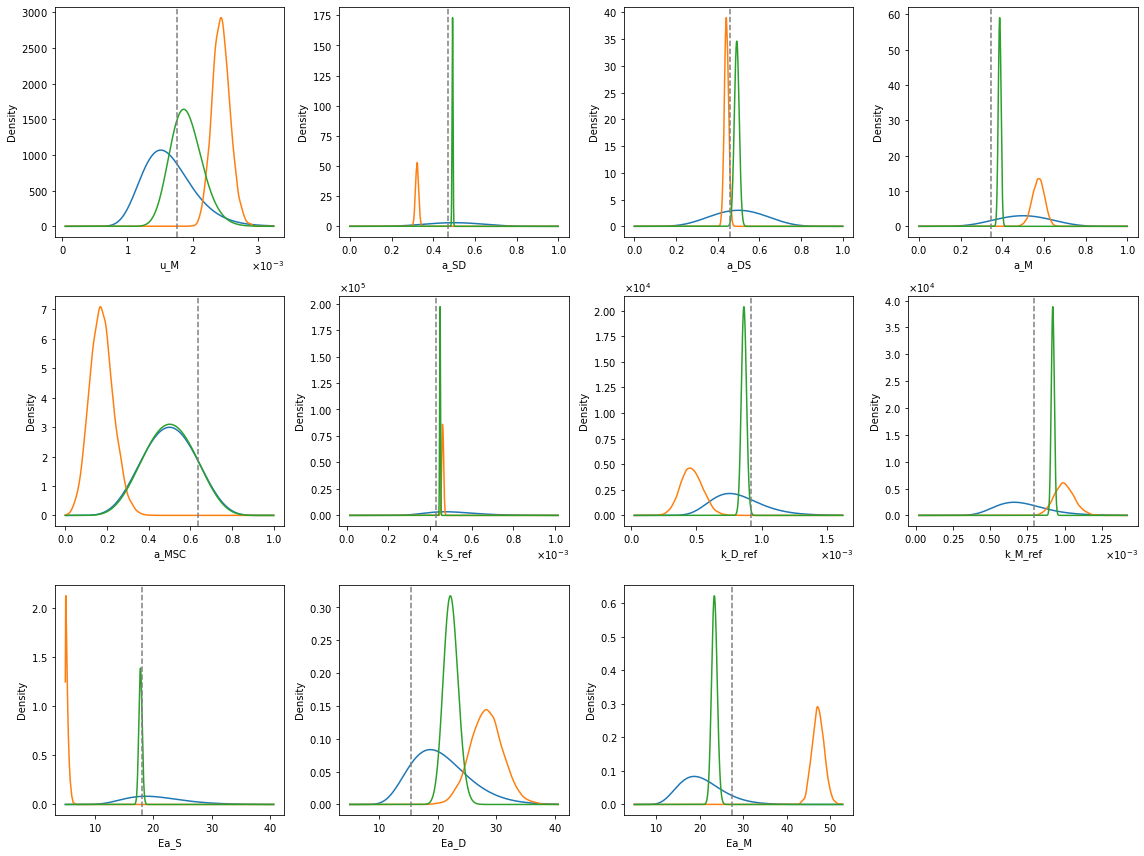

In [17]:
num_params = len(SCON_SS_priors_details)
ncols = 4
nrows = int(num_params / ncols) + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
axes = np.atleast_2d(axes)
k = 0
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        if k < num_params:
            key = keys[k]
            post_kde_density = stats.gaussian_kde(df_post.loc[:, key])
            ax.plot(x[:, k], pdf_prior[:, k])
            ax.plot(x[:, k], post_kde_density(x[:, k]))
            ax.plot(x[:, k], pdf_post_VI[:, k])
            ax.axvline(true_theta[key], color='gray', linestyle = '--')
            ax.set_xlabel(key)
            ax.set_ylabel('Density')
            ax.ticklabel_format(style='sci', scilimits=(-2,4), axis='both', useMathText='True')
        else:
            fig.delaxes(axes[i, j])
        k += 1  
plt.tight_layout()